## Dependances

In [1]:
import os
import sys
import torch
import av
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, VideoMAEForVideoClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, balanced_accuracy_score
from torchsampler import ImbalancedDatasetSampler
import matplotlib.pyplot as plt

# Local dep
project_dir = '/data/konrad/workspace'
sys.path.insert(0, project_dir)
from helpers.helpers import get_indices, load_local_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-08-26 14:11:38.443913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-26 14:11:38.454720: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-26 14:11:38.458015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-26 14:11:38.466266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 14:11:39.137905: W tensorflow/compiler/tf2

In [2]:
# Custom Video Dataset Class
class CalfVideoDataset(Dataset):
    def __init__(self, video_df, processor, max_frames=20, frame_rate = 4, transform = None):
        self.video_df = video_df.reset_index(drop=True)
        self.processor = processor
        self.max_frames = max_frames
        self.frame_rate = frame_rate
        self.transform = transform

        self.labels = self.video_df["target"]
        
        label_to_count = self.labels.value_counts()

        weights = 1.0 / label_to_count[self.labels]

        self.weights = weights.to_list()

    def __len__(self):
        return len(self.video_df)

    def get_labels(self):
        return self.labels

    def get_class_weights(self):
        return torch.FloatTensor(1.0 / self.labels.value_counts())

    def __getitem__(self, idx):
        row_video = self.video_df.loc[idx]
        label = torch.tensor(row_video["target"], dtype=torch.float32)
        container = av.open(row_video["path"])

        video_stream = container.streams.video[0]

        # Get the duration in time base units
        duration_in_units = video_stream.duration
        
        # Get the time base
        time_base = video_stream.time_base
        
        # Calculate the duration in seconds
        duration_in_seconds = duration_in_units * time_base

        # Sample 16 frames
        fps = int(container.streams.video[0].average_rate)
        seg_len = int(duration_in_seconds) * fps
        sample_rate = min(int(seg_len / self.max_frames) - 1, self.frame_rate)

        # sample max_frames frames
        indices = sample_frame_indices(clip_len=self.max_frames, frame_sample_rate=sample_rate, seg_len=seg_len)
        video = read_video_pyav(container=container, indices=indices)

        # if self.transform:
        #     video = self.transform(video.transpose(0, 3, 1, 2))
        
        inputs = self.processor(list(video), return_tensors="pt")

        return {"pixel_values": inputs["pixel_values"][0], "label": label, "weight": self.weights[idx]}


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        weights = inputs.pop("weights")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # print(logits.shape)
        # compute custom loss for 3 labels with different weights
        if self.model.config.num_labels > 1:
            if self.is_in_train:
                weights = self.train_dataset.get_class_weights()
            else:
                weights = self.eval_dataset.get_class_weights()
                
            loss_fct = nn.CrossEntropyLoss(weight=weights.to(model.device))
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.long().view(-1))
        else:
            loss_fct = nn.BCEWithLogitsLoss(weight=weights.to(model.device))
            loss = loss_fct(logits.view(-1, self.model.config.num_labels).flatten(), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss
        
    def get_train_dataloader(self):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset 
        data_collator = self.data_collator

        dataloader_params = {
            "batch_size": self._train_batch_size,
            "collate_fn": data_collator,
            "num_workers": self.args.dataloader_num_workers,
            "pin_memory": self.args.dataloader_pin_memory,
            "persistent_workers": self.args.dataloader_persistent_workers,
            "sampler": ImbalancedDatasetSampler(train_dataset)
        }

        return self.accelerator.prepare(DataLoader(train_dataset, **dataloader_params))

In [3]:
# Define a collate function to handle the feature extractor outputs
def collate_fn(batch):
    # print(torch.stack([item['pixel_values'] for item in batch]).shape)
    # print(batch)
    return {
        'pixel_values': torch.stack([item['pixel_values'] for item in batch]),
        'labels': torch.tensor([item['label'] for item in batch]),
        'weights': torch.tensor([item['weight'] for item in batch]),
    }

def compute_metrics(pred):
    labels = pred.label_ids
    # preds = pred.predictions.argmax(-1)

    if num_labels == 1:
        # For binary classification, assume preds are probabilities and use threshold 0.5
        # print(pred.predictions.shape, pred.predictions)
        probs = torch.sigmoid(torch.tensor(pred.predictions))
        preds = (probs > 0.5).numpy().astype(int).squeeze()
    else:
        # For multi-class classification, take the argmax to get the predicted class labels
        preds = pred.predictions.argmax(-1)

    metric_type = "binary" if num_labels == 1 else "macro"
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=metric_type)
    acc = accuracy_score(labels, preds)
    bal_acc = balanced_accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        "balanced_accuracy": bal_acc
    }

def compute_class_metrics(pred):
    out = {}
    labels = pred.label_ids
    
    if num_labels == 1:
        # For binary classification, assume preds are probabilities and use threshold 0.5
        probs = torch.sigmoid(torch.tensor(pred.predictions))
        preds = (probs > 0.5).numpy().astype(int).squeeze()
    else:
        # For multi-class classification, take the argmax to get the predicted class labels
        preds = pred.predictions.argmax(-1)

    # preds = pred.predictions.argmax(-1)
    metric_type = "binary" if num_labels == 1 else "micro"
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=metric_type)
    acc = accuracy_score(labels, preds)

    report = classification_report(labels, preds, target_names=id2label.values(), output_dict=True)
    bal_acc = balanced_accuracy_score(labels, preds)

    if num_labels > 1:
        for class_name, metrics in report.items():
            if class_name not in ('accuracy', 'macro avg', 'weighted avg'):
                out[f"{class_name}_precision"] = metrics['precision']
                out[f"{class_name}_recall"] = metrics['recall']
                out[f"{class_name}_f1-score"] = metrics['f1-score']

    out.update({
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        "balanced_accuracy": bal_acc
    })
    
    return out
    
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])


def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    # start_idx = end_idx - converted_len
    start_idx = 0
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

def plot_results(log_history):
    # Initialize lists to store metrics over epochs
    train_loss = []
    eval_loss = []
    eval_f1 = []
    eval_accuracy = []
    eval_precision = []
    eval_balanced_accuracy = []
    epochs = []
    
    # Extract metrics from log history
    for log in log_history:
        if 'loss' in log:
            train_loss.append(log['loss'])
        if 'eval_loss' in log:
            eval_loss.append(log['eval_loss'])
            epochs.append(log['epoch'])
        if 'eval_f1' in log:
            eval_f1.append(log['eval_f1'])
        if 'eval_accuracy' in log:
            eval_accuracy.append(log['eval_accuracy'])
        if 'eval_precision' in log:
            eval_precision.append(log['eval_precision'])
        if 'eval_balanced_accuracy' in log:
            eval_balanced_accuracy.append(log['eval_balanced_accuracy'])
    
    # Plot Training and Evaluation Loss
    # print(len(eval_loss), len(epochs), len(train_loss))
    plt.figure(figsize=(10, 5))
    # plt.plot(epochs, train_loss, label="Training Loss")
    plt.plot(epochs, eval_loss, label="Evaluation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss over Epochs")
    plt.legend()
    plt.show()
    
    # Plot Evaluation F1 Score
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, eval_f1, label="Evaluation F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("Evaluation F1 Score over Epochs")
    plt.legend()
    plt.show()
    
    # Plot Evaluation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, eval_accuracy, label="Evaluation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Evaluation Accuracy over Epochs")
    plt.legend()
    plt.show()
    
    # Plot Evaluation Precision
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, eval_precision, label="Evaluation Precision")
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title("Evaluation Precision over Epochs")
    plt.legend()
    plt.show()
    
    # Plot Evaluation Balanced Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, eval_balanced_accuracy, label="Evaluation Balanced Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Balanced Accuracy")
    plt.title("Evaluation Balanced Accuracy over Epochs")
    plt.legend()
    plt.show()

## Training

In [4]:
root_dir = "/data/konrad/workspace/csv_files/mixed_10s_b0s_y7_1/"
data_type = "loco_"
# data_type = "splt_"

train_df = pd.read_csv(f"{root_dir}{data_type}train_video_extracted_metadata.csv", index_col=False)
test_df = pd.read_csv(f"{root_dir}{data_type}val_video_extracted_metadata.csv", index_col=False)
valid_df = pd.read_csv(f"{root_dir}{data_type}test_video_extracted_metadata.csv", index_col=False)

# label_col = "bilabel"
label_col = "label"
train_df = train_df[~ (train_df[label_col] == "Diarrhé, Pneumonie")]
valid_df = valid_df[~ (valid_df[label_col] == "Diarrhé, Pneumonie")]
test_df = test_df[~ (test_df[label_col] == "Diarrhé, Pneumonie")]

labels = train_df[label_col].unique()
label2id = {l:i for i, l in enumerate(labels)}
id2label = {i:l for i, l in enumerate(labels)}
num_labels = len(labels)
# num_labels = 1
train_df['target'] = train_df.apply(lambda row: label2id[row[label_col]], axis=1)
test_df['target'] = test_df.apply(lambda row: label2id[row[label_col]], axis=1)
valid_df['target'] = valid_df.apply(lambda row: label2id[row[label_col]], axis=1)
test_df = test_df.sample(frac=.10).reset_index(drop=True)

train_df.shape, test_df.shape, valid_df.shape

((207, 11), (101, 11), (68, 11))

In [5]:
# # Count the occurrences of each class
# counts = train_df['label'].value_counts()

# # Plot the distribution
# plt.figure(figsize=(17, 6))
# counts.plot(kind='bar')
# plt.title('Distribution of video in Training set of Sampled dataset')
# plt.xlabel('label id')
# plt.ylabel('Count')
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

# # Count the occurrences of each class
# counts = test_df['label'].value_counts()

# # Plot the distribution
# plt.figure(figsize=(17, 6))
# counts.plot(kind='bar')
# plt.title('Distribution of video in Validation set of Sampled dataset')
# plt.xlabel('label id')
# plt.ylabel('Count')
# plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

In [6]:
batch_size = 12
clip_len = 16
epochs = 30
lr = 1e-5
frame_rate = 15
patience = 2

model_name = "MCG-NJU/videomae-base-ssv2"
# model_name = "facebook/timesformer-hr-finetuned-ssv2"
# model_name = "google/vivit-b-16x2-kinetics400"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = VideoMAEForVideoClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True)

train_dataset = CalfVideoDataset(train_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)
test_dataset = CalfVideoDataset(test_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)
valid_dataset = CalfVideoDataset(valid_df, image_processor, max_frames=clip_len, frame_rate = frame_rate)

# Define optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=patience * 3, early_stopping_threshold=0.05)

# Define training arguments
model_dir = f"{model_name}_{data_type}_{label_col}"
ROOT_DIR = "/data/konrad/workspace"
output_dir = ROOT_DIR + "/training_log"
training_args = TrainingArguments(
    output_dir=f'{output_dir}/results/{model_dir}',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=500,
    save_steps=100,
    weight_decay=0.01,
    logging_dir=f'{output_dir}/logs/{model_dir}',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch", 
    metric_for_best_model="f1",
    remove_unused_columns=False,
    load_best_model_at_end = True
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, scheduler),
    data_collator = collate_fn,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback]
)

train_results = trainer.train()
model.save_pretrained(f'{ROOT_DIR}/models/{model_dir}_{clip_len}_{frame_rate}')

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-ssv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/data/konrad/x_env/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/data/konrad/x_env/lib/python3.10/site-packages/transformers/feature_extraction_utils.py:142: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Balanced Accuracy
1,1.105300,1.090408,0.445545,0.440669,0.496078,0.488325,0.488325
2,0.955800,1.043431,0.455446,0.454227,0.485153,0.480372,0.480372
3,0.906900,1.019407,0.425743,0.400277,0.421730,0.424994,0.424994
4,0.758800,0.999012,0.485149,0.469697,0.492512,0.478914,0.478914
5,0.727100,0.989324,0.504950,0.488414,0.500895,0.505581,0.505581
6,0.526600,1.016309,0.514851,0.492404,0.496587,0.498352,0.498352
7,0.467800,1.017893,0.485149,0.461791,0.472211,0.466432,0.466432


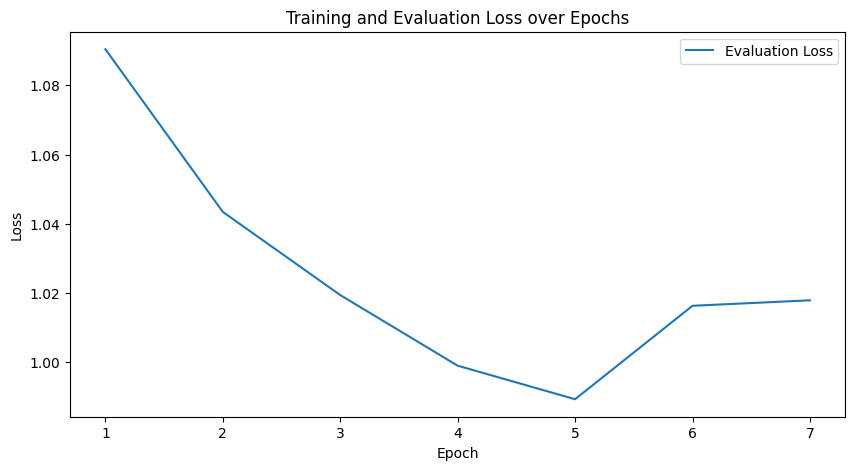

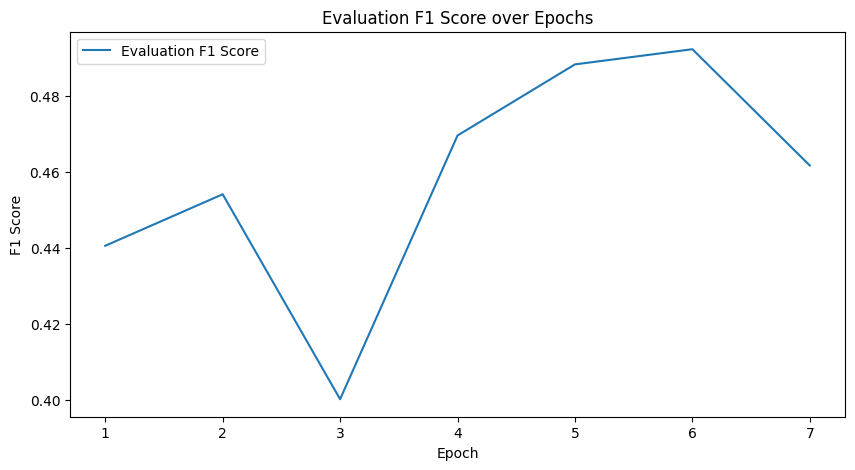

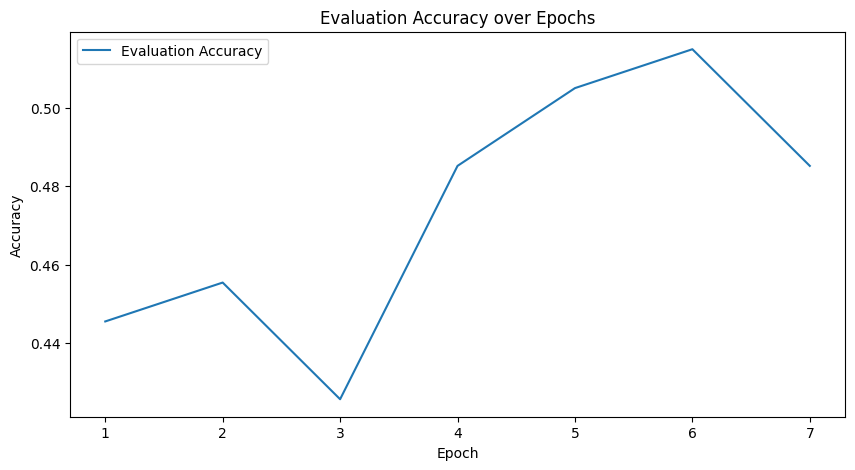

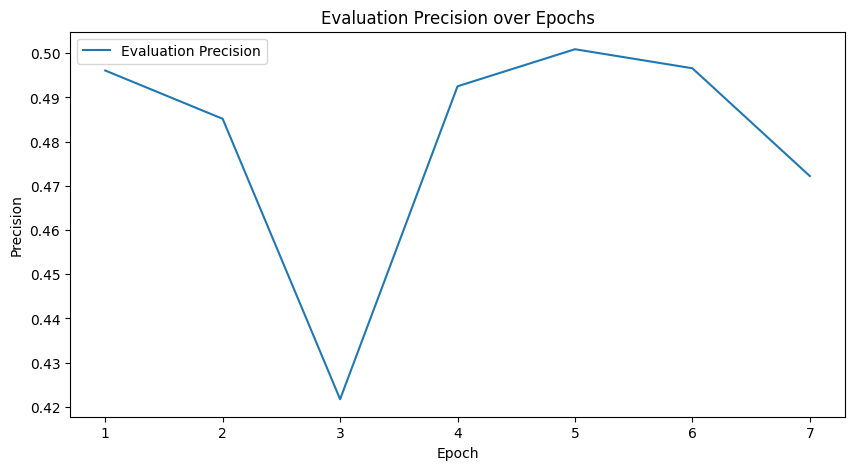

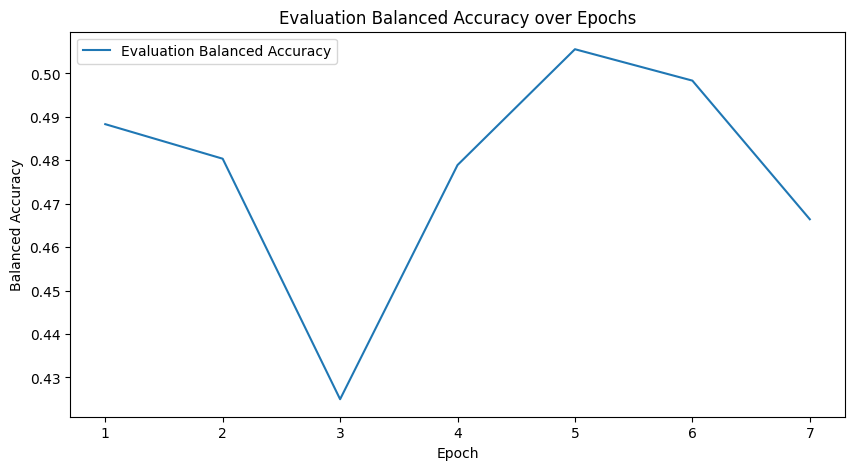

In [7]:
plot_results(trainer.state.log_history)

## Evaluation

In [8]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, scheduler),
    data_collator = collate_fn,
    compute_metrics=compute_class_metrics
)
eval_results = trainer.evaluate(valid_dataset)

metrics = eval_results
print("Global Metrics:")
print(f"Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"F1: {metrics['eval_f1']:.4f}")
print(f"Precision: {metrics['eval_precision']:.4f}")
print(f"Recall: {metrics['eval_recall']:.4f}")
print(f"balanced_accuracy: {metrics['eval_balanced_accuracy']:.4f}")

if num_labels > 1:
    print("\nMetrics per Class:")
    print("Pneumonie:")
    print(f"F1: {metrics['eval_Pneumonie_f1-score']:.4f}")
    print(f"Precision: {metrics['eval_Pneumonie_precision']:.4f}")
    print(f"Recall: {metrics['eval_Pneumonie_recall']:.4f}")
    print("\nDiarrhé:")
    print(f"F1: {metrics['eval_Diarrhé_f1-score']:.4f}")
    print(f"Precision: {metrics['eval_Diarrhé_precision']:.4f}")
    print(f"Recall: {metrics['eval_Diarrhé_recall']:.4f}")
    print("\nHealthy:")
    print(f"F1: {metrics['eval_Healthy_f1-score']:.4f}")
    print(f"Precision: {metrics['eval_Healthy_precision']:.4f}")
    print(f"Recall: {metrics['eval_Healthy_recall']:.4f}")

Global Metrics:
Accuracy: 0.3382
F1: 0.3382
Precision: 0.3382
Recall: 0.3382
balanced_accuracy: 0.3353

Metrics per Class:
Pneumonie:
F1: 0.0000
Precision: 0.0000
Recall: 0.0000

Diarrhé:
F1: 0.1667
Precision: 0.2143
Recall: 0.1364

Healthy:
F1: 0.5405
Precision: 0.3922
Recall: 0.8696
